# Neural prophet weather prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
from neuralprophet import NeuralProphet

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 12)

In [5]:
import warnings
warnings.simplefilter('ignore')

$$
\text { Relative RMSE }=\frac{\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left({Y}_{i}-{V}_{i}\right)^{2}}}{\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left({Y}_{i}-\bar{Y}\right)^{2}}}
$$

In [6]:
def relative_rmse(target, preds):
    rmse = mean_squared_error(target, preds, squared=False)
    avg = np.full(len(preds), preds.mean())
    const_rmse = mean_squared_error(target, avg, squared=False)
    return rmse / const_rmse

### Reading data

In [7]:
weather_df = pd.read_csv('NASA_weather_latitude_51.5_longitude_37.0.csv', skiprows=8)
weather_df["DATE"] = pd.to_datetime(weather_df["DAY"], format='%Y%m%d')

In [8]:
weather_df.head()

,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
0,19840101,2500.0,-5.20,0.26,0.479845,7.59,2.93,NaN,1984-01-01
1,19840102,3250.0,0.30,1.26,0.610800,7.50,2.77,NaN,1984-01-02
2,19840103,4240.0,-1.74,0.99,0.534874,7.11,0.72,NaN,1984-01-03
3,19840104,2740.0,-1.13,0.66,0.592380,5.12,0.44,NaN,1984-01-04
4,19840105,1890.0,-3.70,0.99,0.569003,3.09,0.88,NaN,1984-01-05


### Train - test split

In [9]:
train_tmp = weather_df[weather_df.DATE.dt.year > 1999].copy()
train_data = train_tmp[train_tmp.DATE.dt.year < 2015].copy()

In [10]:
test_tmp = weather_df[weather_df.DATE.dt.year > 2014].copy()
test_data = test_tmp[test_tmp.DATE.dt.year < 2020].copy()

In [11]:
display(train_data.head())
display(test_data.tail())

,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
5844,20000101,3550.0,-12.80,-7.20,0.276993,1.56,1.21,NaN,2000-01-01
5845,20000102,4140.0,-12.74,-6.73,0.297244,3.87,2.47,NaN,2000-01-02
5846,20000103,4590.0,-16.81,-11.44,0.185930,1.34,0.40,NaN,2000-01-03
5847,20000104,4600.0,-15.39,-8.39,0.220140,2.95,0.12,NaN,2000-01-04
5848,20000105,3610.0,-11.50,-5.81,0.310407,3.70,0.65,NaN,2000-01-05


,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
13144,20191227,1280.0,-1.88,0.75,0.547656,1.42,1.23,NaN,2019-12-27
13145,20191228,990.0,-3.79,-1.13,0.423742,3.27,1.59,NaN,2019-12-28
13146,20191229,1070.0,-6.74,-3.27,0.356630,2.94,1.63,NaN,2019-12-29
13147,20191230,750.0,-6.81,-3.80,0.363870,3.76,0.47,NaN,2019-12-30
13148,20191231,1200.0,-3.92,-0.81,0.474842,6.01,2.31,NaN,2019-12-31


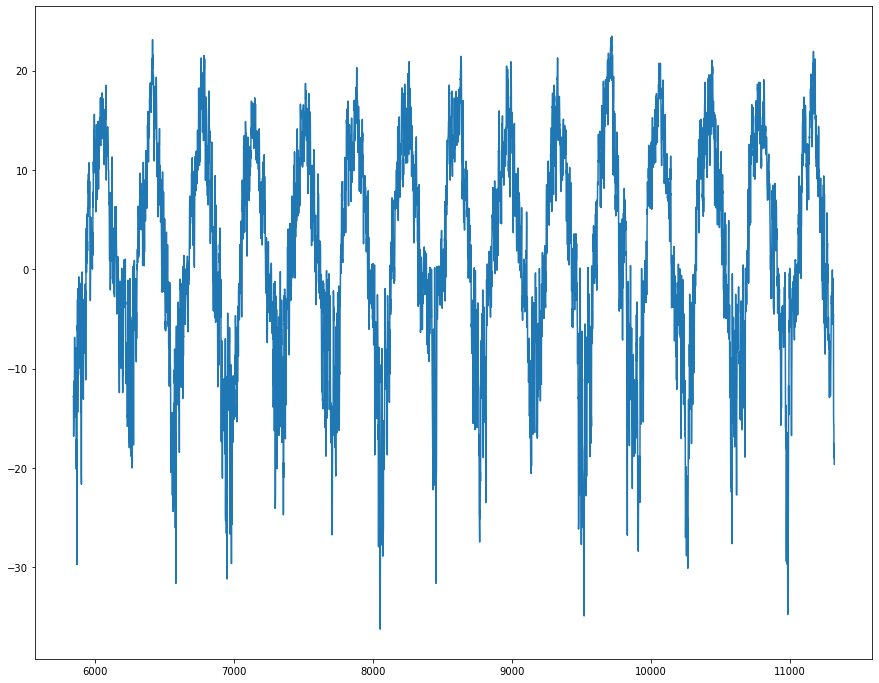

In [12]:
train_data.TMIN.plot();

## Utils

In [13]:
def train_prophet(train, name):
    train_ds = train[['DATE', f'{name}']].copy()
    train_ds.reset_index(drop=True)
    train_ds = train_ds.rename(columns={"DATE": "ds", f"{name}": "y"})

    model = NeuralProphet()
    model.fit(train_ds, freq="D")
    future = model.make_future_dataframe(train_ds, periods=1826, n_historic_predictions=0)
    forecast = model.predict(future)

    return forecast.yhat1.to_numpy()

In [14]:
def visulize(df, name):
    plt.title(f"{name} prediction")
    df[f'{name}'].plot()
    df[f'{name}_np'].plot()
    plt.legend(["Ground Truth", "Yhat"]);

In [15]:
def metrics(df, name):
    rmse = mean_squared_error(df[f'{name}'], df[f'{name}_np'], squared=False)
    rrmse = relative_rmse(df[f'{name}'], df[f'{name}_np'])

    print("RMSE:\t%.4f" % rmse)
    print("Relative RMSE:\t%.4f" % rrmse)

## IRRAD

In [17]:
irrad= train_prophet(train_data, "IRRAD")
test_data['IRRAD_np'] = irrad

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 120


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.07E-02, min: 2.60E+00


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.84E-02, min: 1.08E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.93E-02
Epoch[120/120]: 100%|██████████| 120/120 [00:09<00:00, 12.10it/s, SmoothL1Loss=0.0118, MAE=3.01e+3, RMSE=3.93e+3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [18]:
metrics(test_data, 'IRRAD')

RMSE:	4050.6049
Relative RMSE:	0.4791


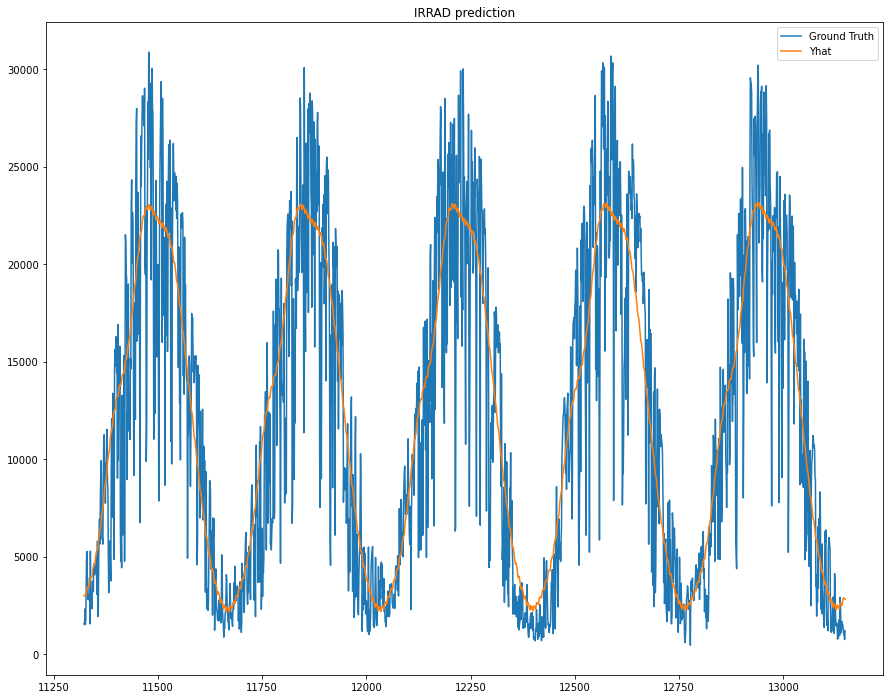

In [19]:
visulize(test_data, 'IRRAD')

## TMIN

In [20]:
tmin= train_prophet(train_data, "TMIN")
test_data['TMIN_np'] = tmin

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 120


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.07E-02, min: 1.25E+00


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.07E-02, min: 1.08E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.37E-02
Epoch[120/120]: 100%|██████████| 120/120 [00:10<00:00, 11.79it/s, SmoothL1Loss=0.00388, MAE=3.59, RMSE=4.64, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [21]:
metrics(test_data, 'TMIN')

RMSE:	4.4503
Relative RMSE:	0.4316


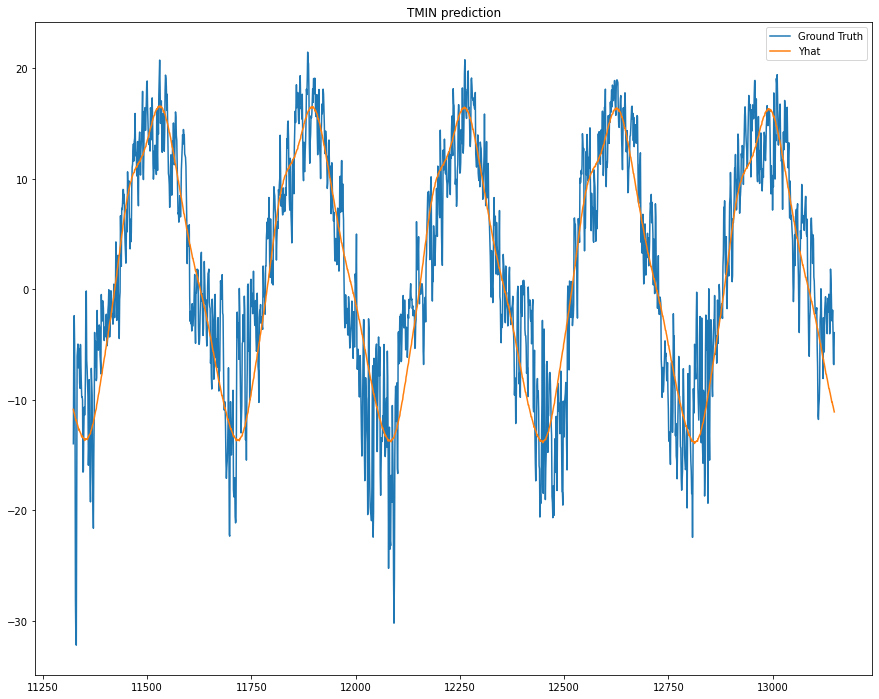

In [22]:
visulize(test_data, 'TMIN')

## TMAX

In [23]:
tmax = train_prophet(train_data, "TMAX")
test_data['TMAX_np'] = tmax

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 120


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 1.25E+00


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 9.37E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.03E-01
Epoch[120/120]: 100%|██████████| 120/120 [00:10<00:00, 11.89it/s, SmoothL1Loss=0.00319, MAE=3.6, RMSE=4.46, RegLoss=0] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [24]:
metrics(test_data, 'TMAX')

RMSE:	4.5713
Relative RMSE:	0.3685


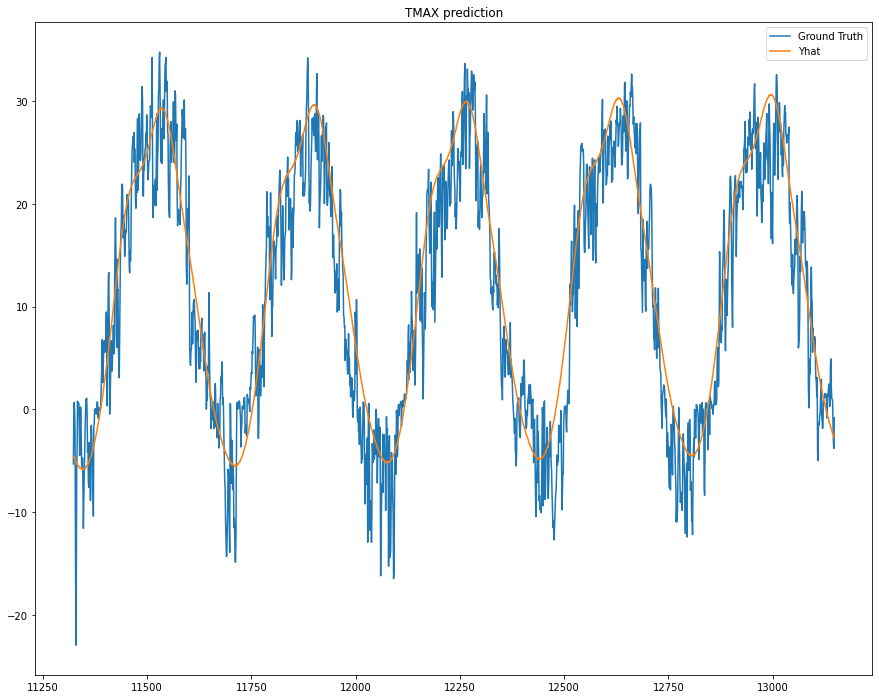

In [25]:
visulize(test_data, 'TMAX')

## VAP

In [26]:
vap = train_prophet(train_data, "VAP")
test_data['VAP_np'] = vap

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 120


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.78E-02, min: 1.25E+00


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.07E-02, min: 1.08E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.50E-02
Epoch[120/120]: 100%|██████████| 120/120 [00:10<00:00, 11.88it/s, SmoothL1Loss=0.00822, MAE=0.178, RMSE=0.223, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [27]:
metrics(test_data, 'VAP')

RMSE:	0.3637
Relative RMSE:	0.6259


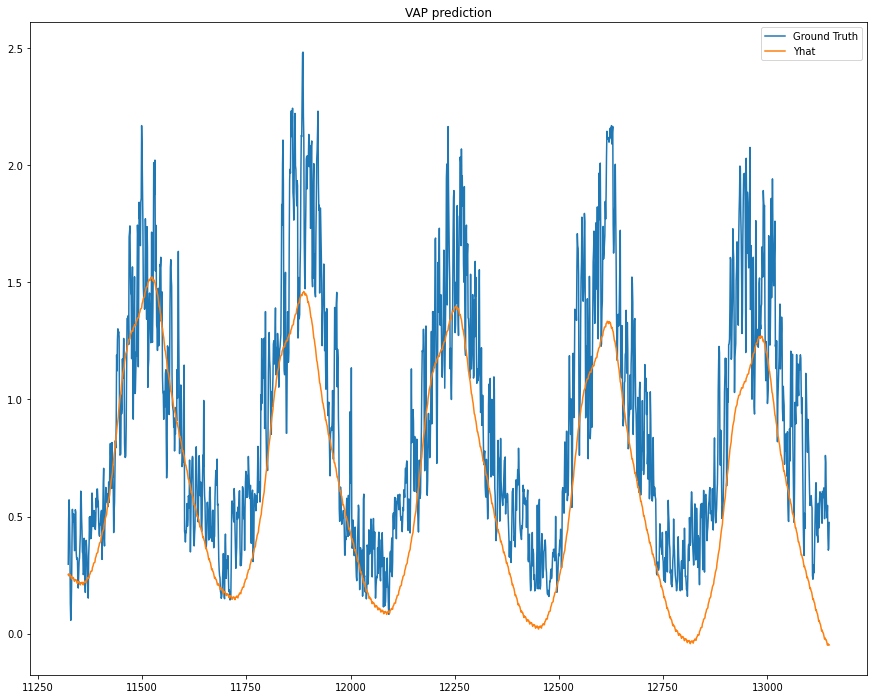

In [28]:
visulize(test_data, 'VAP')

## WIND

In [29]:
wind = train_prophet(train_data, "WIND")
test_data['WIND_np'] = wind

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 120


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.07E-02, min: 1.25E+00


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.07E-02, min: 1.25E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.37E-02
Epoch[120/120]: 100%|██████████| 120/120 [00:10<00:00, 11.93it/s, SmoothL1Loss=0.0293, MAE=0.98, RMSE=1.23, RegLoss=0] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [30]:
metrics(test_data, 'WIND')

RMSE:	1.2597
Relative RMSE:	0.9045


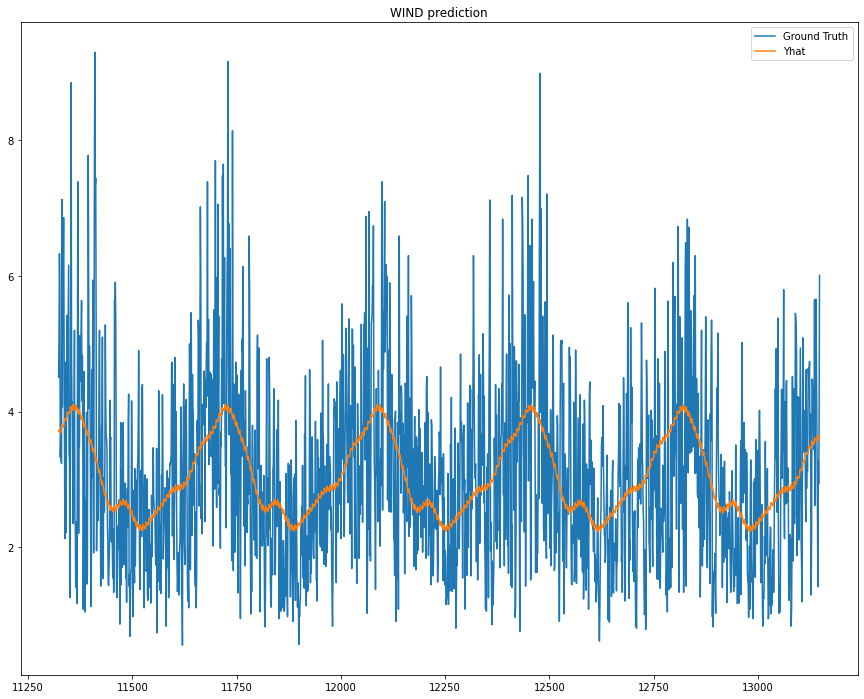

In [31]:
visulize(test_data, 'WIND')

## RAIN

In [32]:
rain = train_prophet(train_data, "RAIN")
test_data['RAIN_np'] = rain

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 120


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 2.60E+00


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 1.08E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.03E-01
Epoch[120/120]: 100%|██████████| 120/120 [00:10<00:00, 11.82it/s, SmoothL1Loss=0.0639, MAE=1.95, RMSE=3, RegLoss=0]   
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [ ]:
metrics(test_data, 'RAIN')

RMSE:	4.4503
Relative RMSE:	0.4316


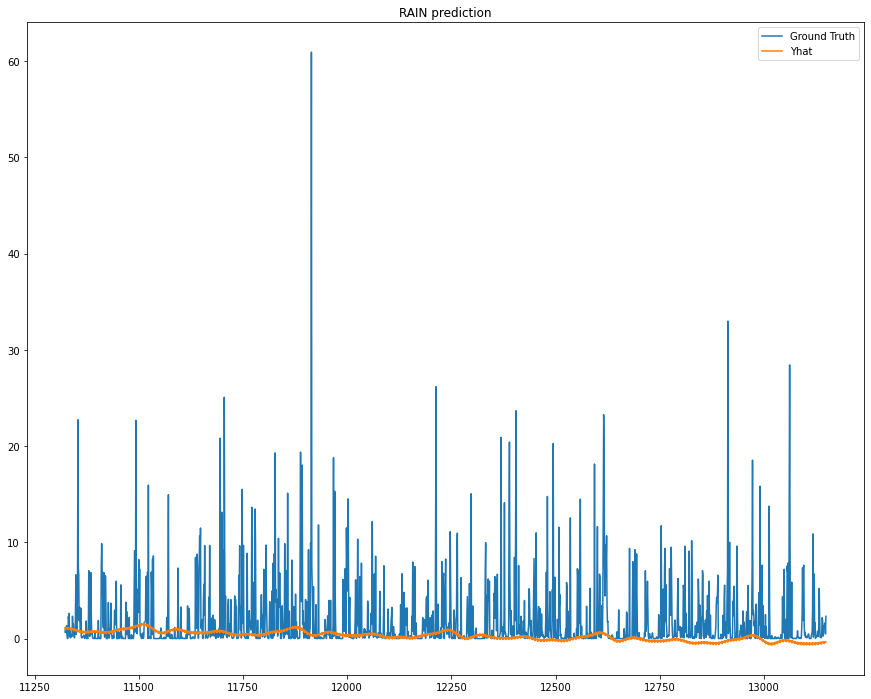

In [33]:
visulize(test_data, 'RAIN')